In [31]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
import numpy as np
import os
import pathlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [32]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("TensorFlow is not using a GPU.")

TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
def load_and_decode_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3)
    return image

def random_blur_image(image):
    sigma = np.random.uniform(1.0, 5.0)  
    filter_shape = (np.random.randint(3, 15), np.random.randint(3, 15))  
    image = tf.expand_dims(image, axis=0)
    blurred_image = tfa.image.gaussian_filter2d(image, filter_shape=filter_shape, sigma=sigma)
    blurred_image = tf.squeeze(blurred_image, axis=0)
    return blurred_image

def show_images_side_by_side(clear_images, blurred_images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))
    
    for i in range(num_images):
        # Get the next image from each dataset
        clear_image = clear_images[i].numpy()
        blurred_image = blurred_images[i].numpy()
        
        # Display clear image
        axes[i, 0].imshow(clear_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Clear Image')

        # Display blurred image
        axes[i, 1].imshow(blurred_image)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Blurred Image')
    
    plt.tight_layout()
    plt.show()

def preprocess_image(image):
    # Ensure the image is a tensor and has the correct shape
    image = tf.ensure_shape(image, [None, None, 3])  # Adjust shape to be flexible
    image = tf.image.resize(image, [256, 256])  # Resize to match model input shape
    image = image / 255.0  # Normalize the image to [0, 1]
    return image

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.concatenate([x, x])  # Skip connection
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.concatenate([x, x])  # Skip connection
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.concatenate([x, x])  # Skip connection
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)  # Assuming output is RGB image

    model = models.Model(inputs, outputs)
    return model

In [34]:
dataset_directory = './ImageSet'
data_dir = pathlib.Path(dataset_directory)
all_image_paths = list(data_dir.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.1, random_state=42)
train_paths, test_paths = train_test_split(all_image_paths, test_size=1.0/9.0, random_state=42)

In [35]:
clear_train = tf.data.Dataset.from_tensor_slices(train_paths)
clear_val = tf.data.Dataset.from_tensor_slices(val_paths)
clear_test = tf.data.Dataset.from_tensor_slices(test_paths)
clear_train = clear_train.map(load_and_decode_image)
clear_val = clear_val.map(load_and_decode_image)
clear_test = clear_test.map(load_and_decode_image)
blurred_train = clear_train.map(random_blur_image)
blurred_val = clear_val.map(random_blur_image)
blurred_test = clear_test.map(random_blur_image)

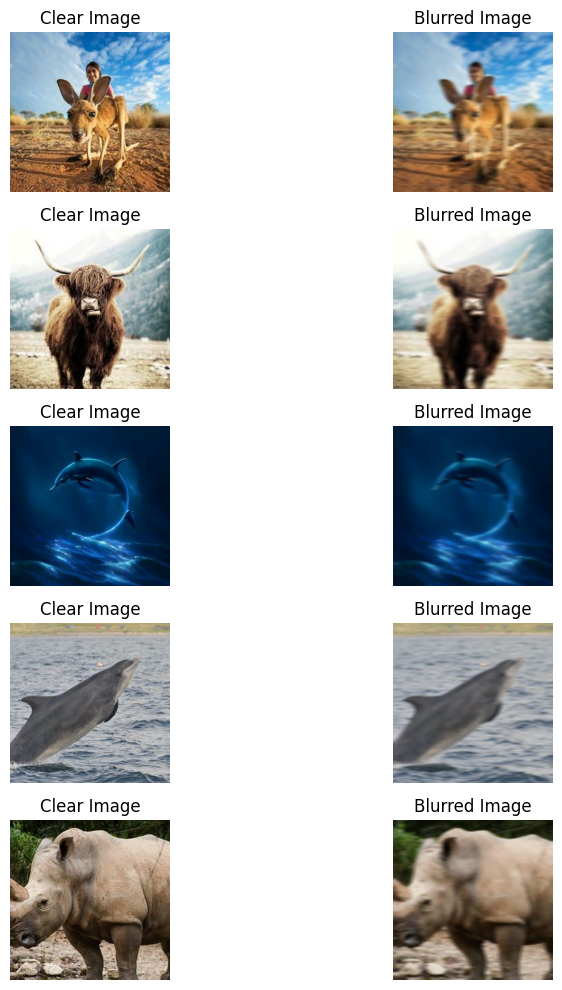

In [36]:
clear_images = [image for image in clear_train.take(5)]
blurred_images = [image for image in blurred_train.take(5)]
show_images_side_by_side(clear_images, blurred_images, num_images=5)

In [37]:
input_shape = (256, 256, 3)

# model = build_model(input_shape)
model = tf.keras.models.load_model("./Models/ImageDeblurModel.h5")

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [38]:
# Apply preprocessing
clear_train = clear_train.map(lambda x: preprocess_image(x))
blurred_train = blurred_train.map(lambda x: preprocess_image(x))
clear_val = clear_val.map(lambda x: preprocess_image(x))
blurred_val = blurred_val.map(lambda x: preprocess_image(x))

# Combine the datasets into a tf.data.Dataset of tuples
train_data = tf.data.Dataset.zip((blurred_train, clear_train))
validation_data = tf.data.Dataset.zip((blurred_val, clear_val))
test_data = tf.data.Dataset.zip((blurred_test, clear_test))

# Shuffle and batch the dataset
train_dataset = train_data.shuffle(100).batch(8)
validation_data = validation_data.shuffle(100).batch(8)
test_data = test_data.shuffle(100).batch(8)

In [39]:
history = model.fit(train_data, validation_data = validation_data, epochs=1)  # Adjust epochs and other parameters as needed
model.save("./Models/ImageDeblurModel.h5")

1375/1375 [==============================] - 505s 366ms/step - loss: 0.0036 - accuracy: 0.8745 - val_loss: 0.0049 - val_accuracy: 0.8957


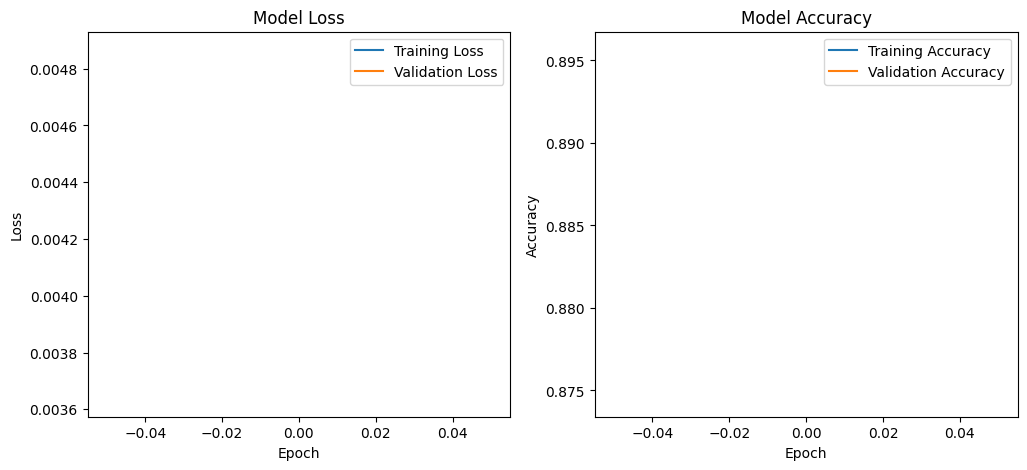

In [40]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()

1/1 [==============================] - 0s 115ms/step


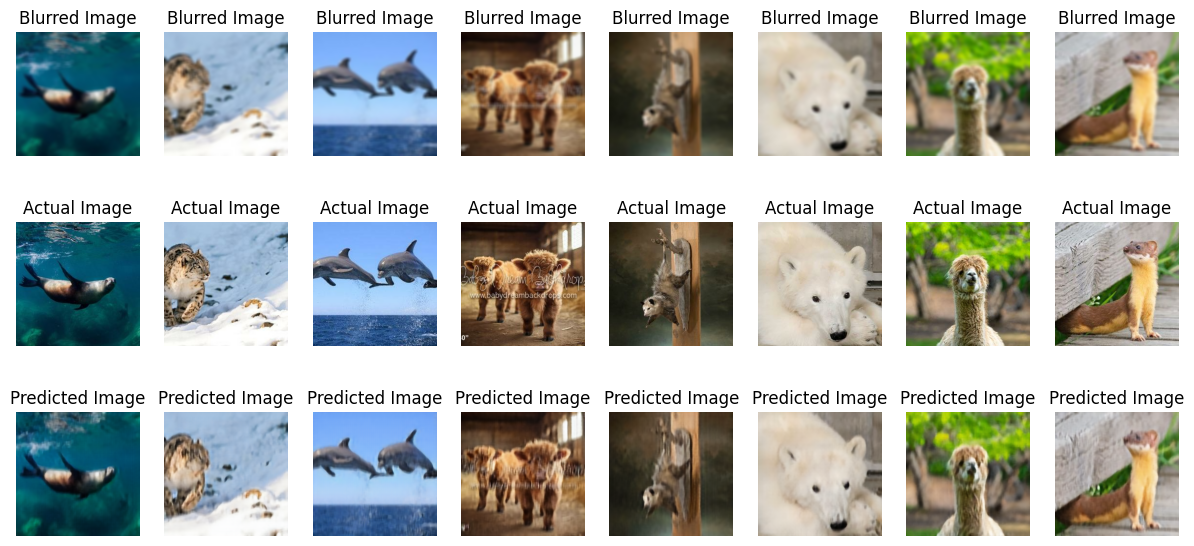

In [41]:
test_images, test_labels = next(iter(test_data))
pred_images = model.predict(test_images)

plt.figure(figsize=(15, 7))

for i in range(len(test_images)):
    # Display the input image
    plt.subplot(3, len(test_images), i + 1)
    plt.imshow(test_images[i])
    plt.title("Blurred Image")
    plt.axis('off')
    
    # Display the corresponding label image
    plt.subplot(3, len(test_images), i + 1 + len(test_images))
    plt.imshow(test_labels[i])
    plt.title("Actual Image")
    plt.axis('off')

    # Display the predicted image
    plt.subplot(3, len(test_images), i + 1 + 2 * len(test_images))
    plt.imshow(pred_images[i])
    plt.title("Predicted Image")
    plt.axis('off')

plt.show()